<font color=yellow size=6>**Dataset generation**</font>

A fairly simple but still not obvious dataset is generated here.

# Imports

In [1]:
import multiprocessing as mltp
from copy import deepcopy
import gc

import numpy as np
import pandas as pd
from scipy.stats.qmc import Sobol # For the sampling

import matplotlib.pyplot as plt

## ENERGY HUB PACKAGES
import sys
sys.path.insert(0, "/home/user/my_packages/")
sys.path.insert(0, "/home/user/my_packages/my_packages/pyehub/")

from my_packages.pyehub import excel_to_request_format
from my_packages.pyehub.energy_hub import EHubModel

In [2]:
building = pd.read_csv("./ElecOnly_MD_Base.csv", index_col=0, parse_dates=[0])

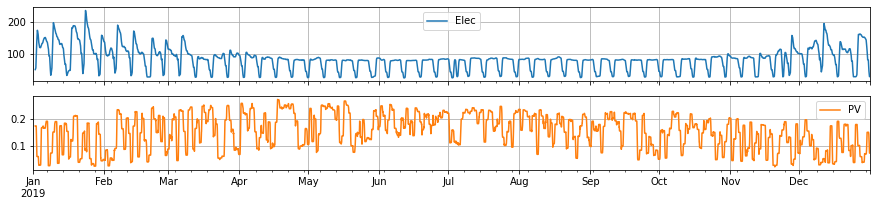

In [3]:
building.rolling(24).mean().plot(figsize=(15,3), grid=True, subplots=True);

# Generate the data

In [4]:
### Sampling
def set_sample_space(n_samples=128):
    """Function containing the parameter space"""
    ### DEFINE THE PARAMETER LIMITS
    parameters = {'elec_import': {'low':.4, 'high':.6}, # cost of electricity
                  'co2': {'low':.2, 'high':.9}, # kg CO2 per kWh elec
                  'gas_import': {'low':.03, 'high':.1}, # Price of kWh gas
                  'elec_export': {'low':-.03, 'high':.03}, # Price of exporting 1kWh of PV
                  'max_carbon': {'low':5, 'high':20}, # Carbon limit
                 }
    parameters = pd.DataFrame(parameters).T
    
    ### GENERATE A SAMPLING
    samples = Sobol(d=parameters.shape[0]).random(n=n_samples)

    # MIX THE PARAMETER VALUES WITH THE SAMPLING
    return pd.DataFrame(np.add( parameters.values[:,0],  np.multiply( samples, np.diff(parameters.values,axis=1).T ) ),
                        columns=parameters.index, dtype='float32')

In [5]:
### Modify the request
def _adapt_request(request, features, week=1):
    
    ### STREAMS
    for req in request['streams']:
        if req['name']=='Elec': ### ELECTRICITY PRICE & CO2
            req['price'] = float(features.loc['elec_import'])
            req['co2'] = float(features.loc['co2'])
        if req['name']=='from_Gas': ### GAS PRICE
            req['price'] = float(features.loc['gas_import'])
        if req['name']=='from_PV': ### PV FEED-IN
            req['export_price'] = float(features.loc['elec_export'])
            
            
    ### TIME SERIES
    idx = building[building.index.isocalendar().week==week].index
    for i,req in enumerate(request['time_series']):
        req['data'] = [float(f) for f in building.loc[idx].values[i]]
            
    return request

In [6]:
### Energy Hub computation
def _get_solution(out):
    return {'Cost':out['solution']['total_cost'], 'Operation':out['solution']['operating_cost'],
            'Carbon': out['solution']['total_carbon'],
            **out['solution']['capacity_tech'], **out['solution']['capacity_storage']}

def compute(i, week):
    local_request = deepcopy(request) # Copy the request to avoid overlaps
    hub = EHubModel(request=_adapt_request(local_request, features.iloc[i], week),
                    max_carbon=float(features.loc[i,'max_carbon'])).solve()
    del local_request; gc.collect() # Free memory space
    return _get_solution(hub)

def generate_set(i):
    """Function generating one sample for each week"""
    individual = [compute(i, week=w) for w in weeks_id]
    return pd.DataFrame(individual)
    

In [7]:
### Sampling
features = set_sample_space(n_samples=32)

### Request
request = excel_to_request_format.convert("./EH_Hub_El.xlsx")



################################
### EXECUTION IN MULTIPROCESSING
weeks_id = np.arange(2,52,8, dtype='int32') # Weeks to consider

with mltp.Pool(processes=16) as pool:
    results = pool.map(generate_set, features.index)

### Gather all results
results = pd.concat(results, axis=0).join(features).loc[:, list(features.columns) + ['Cost','Operation','PV']].reset_index(drop=True)

In [8]:
### TIME SERIES COLLECTION
time_series = [building[building.index.isocalendar().week==w].values for w in weeks_id]
time_series = np.concatenate([time_series for _ in range(features.shape[0])])

# Save data

In [9]:
results.loc[:,'Cost':].to_csv('./y_targets.csv') # Save the targets
results.loc[:,features.columns].to_csv('./X_features.csv') # Save the features
np.savez_compressed('./X_timeSeries.npz', data=time_series) # Save the time series